In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
import matplotlib.pyplot as plt

import numpy as np
import pyroomacoustics as pra
from scipy.io import wavfile

from blind_rt60 import BlindRT60

# Load Data

In [2]:
path: str = r"supplementary_material/data/sp09.wav"

# Import a mono wavfile as the source signal
fs, audio = wavfile.read(os.path.join('..', path))

# Room Simulation

## Create the Room

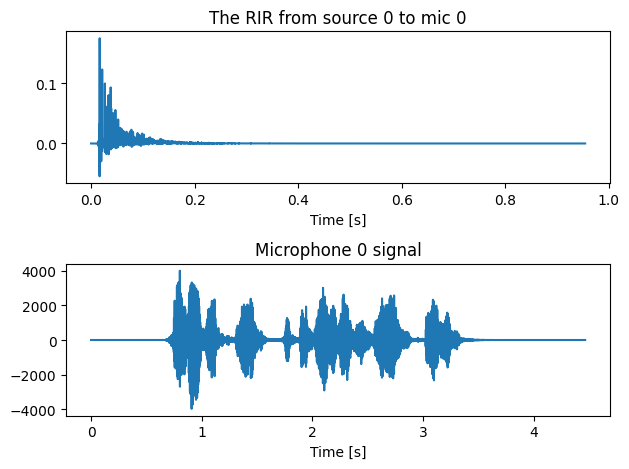

In [3]:
rt60_tgt = 0.3


# Create the room
room_dim = [10, 7.5, 3.5]  # meters
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)  # Invert Sabine's formula, ISM simulator

room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order
)

# Place the source in the room
room.add_source([2.5, 3.73, 1.76], signal=audio, delay=0.5)

# Define the locations of the microphones
mic_locs = np.c_[
    [6.3, 4.87, 1.2], 
]
room.add_microphone_array(mic_locs)

# Run the simulation
room.simulate()

# Create a plot
plt.figure()

# plot one of the RIR. both can also be plotted using room.plot_rir()
rir_1_0 = room.rir[0][0]
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(rir_1_0)) / room.fs, rir_1_0)
plt.title("The RIR from source 0 to mic 0")
plt.xlabel("Time [s]")

# plot signal at microphone 0
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(room.mic_array.signals[0, :])) / room.fs, room.mic_array.signals[0, :])
plt.title("Microphone 0 signal")
plt.xlabel("Time [s]")

plt.tight_layout()

## Compute Schroeder RT60

In [4]:
rt60_schroeder = room.measure_rt60()[0, 0,...]
print(f'Schroeder RT60: {rt60_schroeder:.2f} sec')

Schroeder RT60: 0.40 sec


# Blind RT60 Measurement

Iteration 1000 / 1000; rt60 0.50 sec; tau 0.07 sec
Blind RT60: 0.50 sec


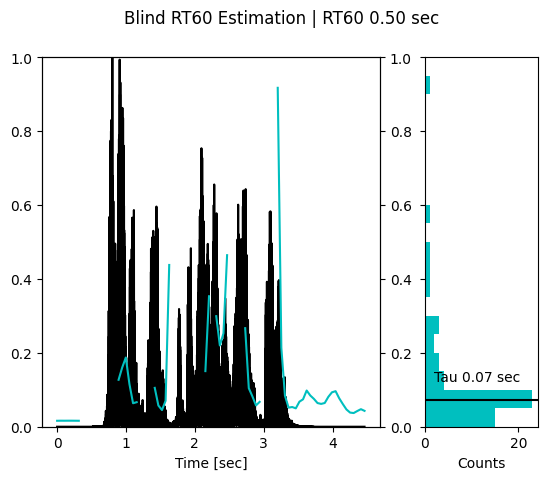

In [5]:
blind_rt60 = BlindRT60(verbose=True)
rt60_estimations = np.array([blind_rt60(room.mic_array.signals[i, ...], fs)
                             for i in range(mic_locs.shape[-1])])[0]
print(f'Blind RT60: {rt60_estimations:.2f} sec')
fig = blind_rt60.visualize(room.mic_array.signals[0, ...], fs)
fig.savefig(r'..\supplementary_material\graphs\BlindRT60.jpg')